# Natural Language Processing: Week 3 - Sequence Models

자연어처리에서는 단어의 순서, 즉 sequence가 중요하게 작용한다.

기본적인 모델은 data와 label을 받아 rule을 output한다고 할 수 있는데, 여기에서는 sequence를 고려하지 않고 있음을 알 수 있다.

이와 달리 Sequence를 고려하는 모델을 만들고자 한 데에서 나온 아이디어는 RNN(Recurrent Neural Network)의 기본 아이디어가 되었다.

![image](https://user-images.githubusercontent.com/76294398/140466261-47fe0c13-07bc-4b9e-8f2e-5eec7f2a3e90.png)


## LSTMs

다음과 같은 문장이 있다고 생각해보자.

> Today has a beautiful blue <...>.

맥락상 <...>안에는 sky가 들어갈 것이라고 예측할 수 있다. 이는 빈칸 앞 문장의 맥락을 통해 파악한 것인데, 이것을 Context라고 하며, 이를 이용해 모델이 빈칸에 들어갈 말을 예측할 수 있게 할 수 있다.

RNN에서 앞선 문장의 Context가 전체로 이어지게 하는 Cell State라는 추가적인 파이프라인을 추가한 것이 바로 LSTM(Long-Short Term Memory unit)이다.

이는 양방향으로 작용하며 뒤 문장의 Context를 앞으로 가져와 빈칸을 채우기도 한다.

![image](https://user-images.githubusercontent.com/76294398/140467518-3970f216-6c86-47f5-b33a-8f66609012ac.png)

### IMDB Subwords 8K with Single Layer LSTM

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals # Pyhton3의 문법을 Python2에서도 사용가능하게 만들어주는 문법. Python3를 사용하고 있다면 굳이 실행시키지 않아도 된다.

import tensorflow_datasets as tfds
import tensorflow as tf

tf.__version__

'2.7.0'

In [3]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2SM8E1/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2SM8E1/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2SM8E1/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
tokenizer = info.features['text'].encoder

In [5]:
# configuration
BUFFER_SIZE = 10_000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary() # Bidirectional이기에 64 * 2 = 128

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 173s 419ms/step - loss: 0.6624 - accuracy: 0.6056 - val_loss: 0.6686 - val_accuracy: 0.5910
Epoch 2/10
391/391 [==============================] - 155s 395ms/step - loss: 0.4965 - accuracy: 0.7655 - val_loss: 0.5505 - val_accuracy: 0.7492
Epoch 3/10
391/391 [==============================] - 156s 397ms/step - loss: 0.4356 - accuracy: 0.8061 - val_loss: 0.4832 - val_accuracy: 0.7904
Epoch 4/10
391/391 [==============================] - 159s 406ms/step - loss: 0.3983 - accuracy: 0.8337 - val_loss: 0.4717 - val_accuracy: 0.7955
Epoch 5/10
391/391 [==============================] - 159s 405ms/step - loss: 0.3398 - accuracy: 0.8601 - val_loss: 0.4437 - val_accuracy: 0.8158
Epoch 6/10
391/391 [==============================] - 159s 404ms/step - loss: 0.2632 - accuracy: 0.8984 - val_loss: 0.4481 - val_accuracy: 0.8089
Epoch 7/10
391/391 [==============================] - 158s 403ms/step - loss: 0.2204 - accuracy: 0.9164 - val_loss: 0.4387 -

#### Visualize

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

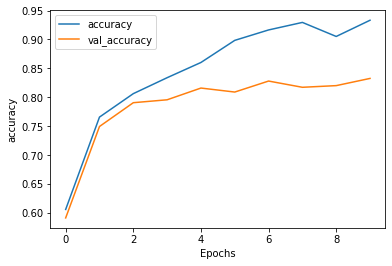

In [11]:
plot_graphs(history, 'accuracy')

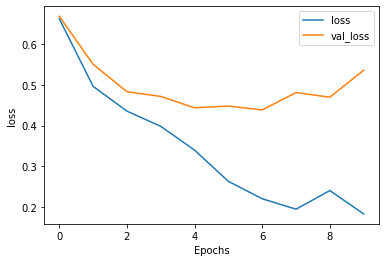

In [12]:
plot_graphs(history, 'loss')

### IMDB Subwords 8K with Multi Layer LSTM

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-tr

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 319s 797ms/step - loss: 0.5655 - accuracy: 0.7113 - val_loss: 0.4671 - val_accuracy: 0.7866
Epoch 2/10
391/391 [==============================] - 305s 778ms/step - loss: 0.3843 - accuracy: 0.8427 - val_loss: 0.4478 - val_accuracy: 0.8000
Epoch 3/10
391/391 [==============================] - 302s 771ms/step - loss: 0.4201 - accuracy: 0.8141 - val_loss: 0.5025 - val_accuracy: 0.7840
Epoch 4/10
391/391 [==============================] - 303s 774ms/step - loss: 0.3960 - accuracy: 0.8277 - val_loss: 0.5347 - val_accuracy: 0.6985
Epoch 5/10
391/391 [==============================] - 304s 777ms/step - loss: 0.3173 - accuracy: 0.8692 - val_loss: 0.4457 - val_accuracy: 0.8249
Epoch 6/10
391/391 [==============================] - 305s 777ms/step - loss: 0.2192 - accuracy: 0.9175 - val_loss: 0.4395 - val_accuracy: 0.8299
Epoch 7/10
391/391 [==============================] - 306s 780ms/step - loss: 0.1723 - accuracy: 0.9369 - val_loss: 0.4552 -

#### Visualize

In [17]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

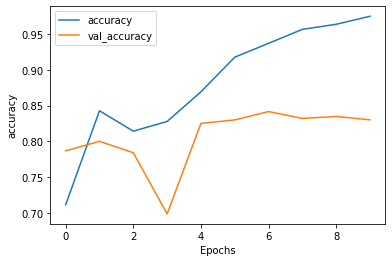

In [18]:
plot_graphs(history, 'accuracy')

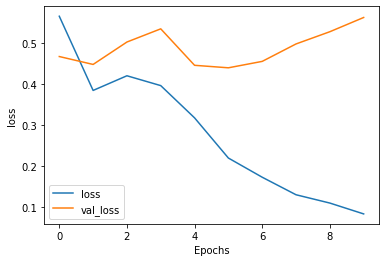

In [19]:
plot_graphs(history, 'loss')

## Using a convolutional network

### IMDB Subwords 8K with 1D Convolutional Layer - Multiple Layer GRU

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
________________________________________________

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 72s 116ms/step - loss: 0.4622 - accuracy: 0.7708 - val_loss: 0.3161 - val_accuracy: 0.8771
Epoch 2/10
391/391 [==============================] - 22s 54ms/step - loss: 0.2320 - accuracy: 0.9166 - val_loss: 0.3111 - val_accuracy: 0.8784
Epoch 3/10
391/391 [==============================] - 20s 48ms/step - loss: 0.1729 - accuracy: 0.9372 - val_loss: 0.3244 - val_accuracy: 0.8760
Epoch 4/10
391/391 [==============================] - 18s 43ms/step - loss: 0.1388 - accuracy: 0.9508 - val_loss: 0.3504 - val_accuracy: 0.8732
Epoch 5/10
391/391 [==============================] - 18s 43ms/step - loss: 0.1113 - accuracy: 0.9615 - val_loss: 0.4196 - val_accuracy: 0.8680
Epoch 6/10
391/391 [==============================] - 17s 42ms/step - loss: 0.0914 - accuracy: 0.9695 - val_loss: 0.4858 - val_accuracy: 0.8622
Epoch 7/10
391/391 [==============================] - 17s 41ms/step - loss: 0.0706 - accuracy: 0.9780 - val_loss: 0.5749 - val_accuracy

#### Visualize

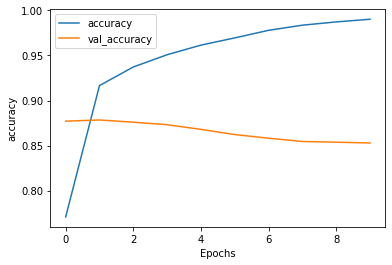

In [24]:
plot_graphs(history, 'accuracy')

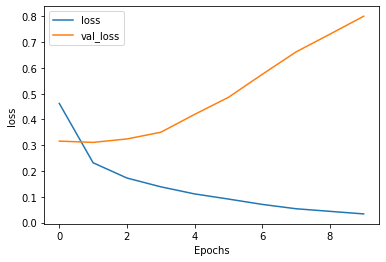

In [25]:
plot_graphs(history, 'loss')

### IMDB Reviews with GRU (and optional LSTM and Conv1D)

In [26]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2.7.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL1PJKU/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL1PJKU/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL1PJKU/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [27]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [28]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [29]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [32]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 50s 60ms/step - loss: 0.5766 - accuracy: 0.6633 - val_loss: 0.3723 - val_accuracy: 0.8360
Epoch 2/50
782/782 [==============================] - 46s 59ms/step - loss: 0.3246 - accuracy: 0.8646 - val_loss: 0.3497 - val_accuracy: 0.8460
Epoch 3/50
782/782 [==============================] - 46s 59ms/step - loss: 0.2408 - accuracy: 0.9065 - val_loss: 0.3656 - val_accuracy: 0.8443
Epoch 4/50
782/782 [==============================] - 46s 58ms/step - loss: 0.1835 - accuracy: 0.9305 - val_loss: 0.4155 - val_accuracy: 0.8322
Epoch 5/50
782/782 [==============================] - 46s 59ms/step - loss: 0.1301 - accuracy: 0.9537 - val_loss: 0.4691 - val_accuracy: 0.8278
Epoch 6/50
782/782 [==============================] - 46s 58ms/step - loss: 0.0851 - accuracy: 0.9708 - val_loss: 0.6274 - val_accuracy: 0.8206
Epoch 7/50
782/782 [==============================] - 46s 58ms/step - loss: 0.0548 - accuracy: 0.9815 - val_loss: 0.8311 - val_accuracy:

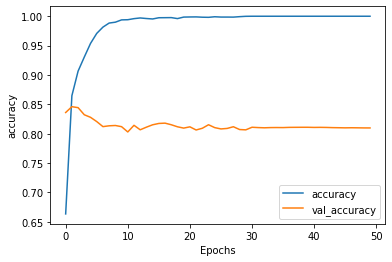

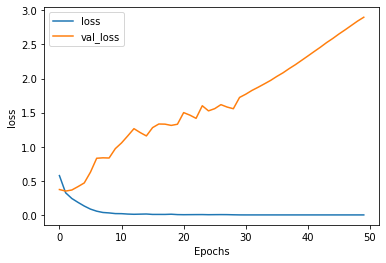

In [33]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [34]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

## Exploring different sequence models

### Sarcasm with Bidirectional LSTM

In [38]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 86.2MB/s]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           16000     
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 24)                1560      
                                                                 
 dense_13 (Dense)            (None, 1)                 25        
                                                                 
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_____________________________

#### Visualize

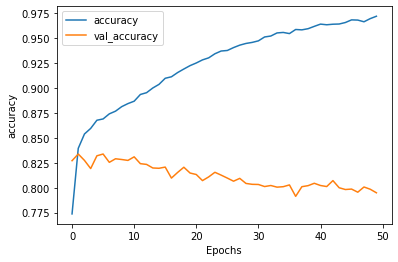

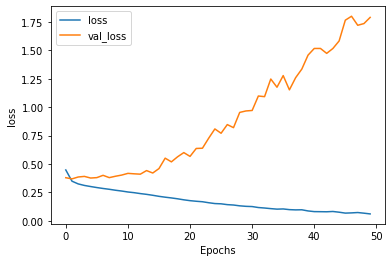

In [39]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#### Model Save

In [40]:
model.save("test.h5")

### Sarcasm with 1D Convolutional Layer

In [41]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 88.3MB/s]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           16000     
                                                                 
 conv1d_2 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_14 (Dense)            (None, 24)                3096      
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                 

#### Visualize

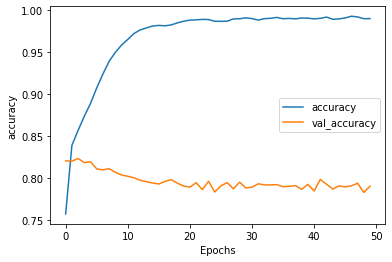

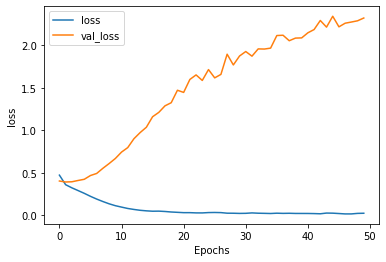

In [42]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#### Model Save

In [43]:
model.save("test2.h5")

## Week 3 Quiz

총점 8점

### 질문 1

Why does sequence make a large difference when determining semantics of language?

- Because the order in which words appear dictate their impact on the meaning of the sentence

## 질문 2

How do Recurrent Neural Networks help you understand the impact of sequence on meaning?

- They carry meaning from one cell to the next

### 질문 3
How does an LSTM help understand meaning when words that qualify each other aren’t necessarily beside each other in a sentence?

- Values from earlier words can be carried to later ones via a cell state

### 질문 4
What keras layer type allows LSTMs to look forward and backward in a sentence?

- Bidirectional

### 질문 5
What’s the output shape of a bidirectional LSTM layer with 64 units?

- (None, 128)

### 질문 6
When stacking LSTMs, how do you instruct an LSTM to feed the next one in the sequence?

- Ensure that return_sequences is set to True only on units that feed to another LSTM

### 질문 7
If a sentence has 120 tokens in it, and a Conv1D with 128 filters with a Kernal size of 5 is passed over it, what’s the output shape?

- (None, 116, 128)

### 질문 8
What’s the best way to avoid overfitting in NLP datasets?

- None of the above